# Sequence Autoencoder Experiment (Figure 5)

## Experiment Overview

This notebook implements the sequence learning experiment from Figure 5 of the Vector-HaSH paper. The experiment demonstrates how deep autoencoders can learn to predict sequential patterns from neural activity, and evaluates the capacity limits and robustness of sequence learning under different conditions.

## Key Concepts

**Sequence Learning**: The ability to learn temporal dependencies in data, where the network predicts the next pattern in a sequence based on the current pattern.

**Autoencoder Architecture**: A neural network that compresses input data into a lower-dimensional latent representation (encoding) and then reconstructs the original data (decoding).

**Pattern Capacity**: The maximum number of sequential patterns a network can reliably learn and reproduce without significant degradation in performance.

**Nonlinearity Effects**: How applying sign nonlinearity at each timestep affects the network's ability to maintain sequential coherence.

## Core Parameter Reference Table

| Parameter Category | Parameter | Shape | Meaning | Row/Column Details |
|-------------------|-----------|-------|---------|-------------------|
| **Network Architecture** | `Np` | scalar | Hidden layer size (Place cells) | 275 - Intermediate representation layer |
| | `Ng` | scalar | Latent layer size (Grid cells) | 38 - Compressed representation bottleneck |
| | `Ns` | scalar | Input/Output dimension | 900 - Sensory input dimension |
| | `Npatts` | scalar | Number of patterns in sequence | Variable (1-3600) - Sequence length |
| **Data Structures** | `sbook` | (Npatts, Ns) | Sequence pattern codebook | Each `sbook[i,:]` = binary pattern for sequence step i |
| | `true_data` | (Npatts, Ns) | Ground truth sequence data | Clean reference patterns for training |
| | `cts_corrupt` | (Npatts, Ns) | Corrupted input data | Noisy version of true_data for testing |
| | `decoded_data` | (Npatts, Ns) | Network predictions | Sequential predictions from autoencoder |
| **Training Parameters** | `Npatts_list` | (72,) | Pattern count sweep | Range from 1 to 3600 in steps of 50 |
| | `nruns` | scalar | Number of experimental runs | 3 - For statistical averaging |
| | `epochs` | scalar | Training iterations | 1000 - Autoencoder training epochs |
| **Noise Parameters** | `test_noise_frac` | scalar | Corruption probability | 0.0 - No noise condition |
| | `test_noise_frac1` | scalar | Corruption probability with nonlin | 0.0 - With sign nonlinearity |
| | `p` | scalar | Noise parameter in corrupt_p | Controls corruption intensity |
| **Performance Metrics** | `final_clean_overlap_list` | (72, 3) | Clean condition results | Each `[i,j]` = overlap for Npatts_list[i], run j |
| | `final_noisy_overlap_list` | (72, 3) | Noisy condition results | Performance with sign nonlinearity |
| | `overlap` | scalar | Pattern similarity measure | Normalized dot product between patterns |

## Key Relations

### Network Capacity Relations
- **`Npatts ≤ Ng`**: For optimal performance, sequence length should not exceed latent dimension
- **`Compression ratio = Ns/Ng`**: 900/38 ≈ 23.7× compression from input to latent space
- **`Information bottleneck`**: Ng dimensions must capture essence of Npatts×Ns information

### Sequence Learning Relations
- **`decoded_data[i] = f(decoded_data[i-1])`**: Each prediction depends on previous step
- **`true_data[:-1] → true_data[1:]`**: Training on (input, target) pairs from consecutive sequence steps
- **`Sequential dependency`**: Network learns temporal structure, not just static patterns

### Performance Relations
- **`overlap = ⟨x̂, x⟩ / (||x̂|| ||x||)`**: Normalized similarity between predicted and true patterns
- **`capacity limit`**: Performance degrades when Npatts exceeds network representational capacity
- **`nonlinearity effect`**: Sign function at each step may help or hinder sequence coherence

## Experimental Design

### 1. Autoencoder Architecture
- **Encoder**: Ns → Np → Ng (900 → 275 → 38 neurons)
- **Decoder**: Ng → Np → Ns (38 → 275 → 900 neurons)
- **Activation**: Tanh nonlinearity for smooth gradients

### 2. Sequence Learning Protocol
- **Training**: Learn to predict next pattern from current pattern
- **Testing**: Generate full sequence from initial pattern
- **Evaluation**: Compare generated sequences to ground truth

### 3. Capacity Analysis
- **Pattern sweep**: Test sequence lengths from 1 to 3600 patterns
- **Multiple runs**: Average over 3 independent experiments
- **Noise conditions**: Compare clean vs. sign-nonlinearity conditions

### 4. Performance Metrics
- **Overlap measure**: Normalized correlation between predicted and true patterns
- **Capacity curves**: Performance vs. sequence length plots
- **Statistical analysis**: Mean and variance across runs

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

$\textcolor{red}{Ji \ Lab \ newly \ added}$:

If you are using a Windows system and encounter the following warning：


`findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica`

please run the next cell regarding font configuration.

In [ ]:
plt.style.use('./src/presentation.mplstyle')
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False 

## 1. Module Import and Environment Setup

Import necessary libraries for deep learning and sequence analysis:

### Core Libraries
- **numpy**: Numerical computations and array operations
- **matplotlib**: Plotting and visualization for performance curves
- **pandas**: Data manipulation and analysis
- **tensorflow**: Deep learning framework for autoencoder implementation

### Machine Learning Components
- **sklearn**: Performance metrics (accuracy, precision, recall) and data splitting
- **tensorflow.keras**: High-level neural network API for model construction
- **layers, losses**: Neural network building blocks and loss functions
- **Model**: Base class for custom autoencoder architecture

### Data Source
- **fashion_mnist**: Though imported, not used in this experiment (legacy import)
- **custom data**: Experiment uses binary pattern sequences for testing

## 2. Data Loading and Utility Functions

### 2.1 Data Loading and Preprocessing

Load pre-processed sensory data and define utility functions for sequence learning experiments:

In [9]:
data_features = np.load('BW_miniimagenet_3600_60_60.npy').reshape((3600,3600))

### 2.2 Sensory Data Loading

Load pre-processed Mini-ImageNet dataset for sequence learning experiments:

**Data source**: `BW_miniimagenet_3600_60_60.npy` contains black-and-white processed Mini-ImageNet images
**Original shape**: 3600 images of 60×60 pixels each
**Reshaping**: Convert to (3600, 3600) matrix where each row is a flattened image
**Purpose**: This large sensory codebook provides diverse patterns for sequence learning experiments

In [10]:
def corrupt_p(codebook,p=0.1,booktype='01'):
  rand_indices = np.sign(np.random.uniform(size=codebook.shape)- p )
  if booktype=='-11':
    return np.multiply(codebook,rand_indices)
  elif booktype=='01':
    return abs(codebook - 0.5*(-rand_indices+1))
  elif booktype=='cts':
    return codebook + np.random.normal(0,1,size=codebook.shape)*p
  else:
    print("codebook should be -11; 01; or cts")
    return 0


### 2.3 Noise Corruption Function

Define function to add controlled noise to test pattern robustness:

**Purpose**: `corrupt_p` function adds different types of noise to test data
**Parameters**:
- `codebook`: Input data matrix to be corrupted
- `p`: Noise probability/intensity (0.0 = no noise, 1.0 = maximum noise)
- `booktype`: Type of corruption applied

**Noise Types**:
- **`'-11'`**: Bipolar corruption - randomly flip signs of elements
- **`'01'`**: Binary corruption - randomly flip 0/1 values  
- **`'cts'`**: Continuous corruption - add Gaussian noise

**Implementation**: Uses random thresholding to determine which elements get corrupted

In [11]:
sbook = data_features - np.mean(data_features.flatten())

### 2.4 Data Preprocessing
$\textcolor{red}{Ji \ lab \ newly\ adds\ : \ the \ original \ code \ forgot \ the \ definition \ of }$ `Npatts` `Ns`

Center the sensory data by removing the mean:

**Centering operation**: Subtract global mean from all data points

**Purpose**: Zero-center the data for better neural network training performance

**Result**: `sbook` becomes mean-centered version of loaded Mini-ImageNet features

In [ ]:
######
Npatts = 3600
Ns = 3600
######
sbook = np.sign(np.random.uniform(size=(Npatts,Ns))-0.5)
sbook = 0.5*(sbook+1)

### 2.5 Random Binary Pattern Generation

Generate random binary patterns for controlled sequence learning experiments:

**Pattern generation**:
1. **Random signs**: `np.sign(np.random.uniform(...) - 0.5)` creates ±1 values
2. **Binary conversion**: `0.5*(sbook + 1)` converts ±1 to 0/1 format
3. **Result**: `sbook` becomes a matrix of random binary patterns

**Purpose**: Creates standardized test sequences with known statistical properties
**Advantage**: Unlike real image data, these patterns have controlled complexity for capacity analysis

In [13]:
def cleanup(s, sbook):
  idx = np.argmax(sbook@s)
  sclean = sbook[idx,:]
  return sclean

### 2.6 Pattern Cleanup Function

Implement pattern cleanup using nearest neighbor search in the codebook:

**Function**: `cleanup(s, sbook)` finds the closest stored pattern to a noisy input
**Algorithm**:
1. **Similarity search**: Compute dot product `sbook @ s` for all stored patterns
2. **Best match**: Find index of pattern with highest similarity
3. **Clean output**: Return the exact stored pattern (noise-free version)

**Purpose**: This implements a form of associative memory cleanup, similar to Hopfield networks
**Use case**: Recovery of clean patterns from corrupted network outputs

In [14]:
def binarize(data,bin_type='01'):
  if bin_type=='01':
    return 0.5*(np.sign(data - 0.5)+1)
  elif bin_type=='-11':
    return np.sign(data)

### 2.7 Data Binarization Function

Convert continuous data to binary format using threshold operations:

**Function**: `binarize(data, bin_type)` applies different binarization schemes
**Binary types**:
- **`'01'`**: Convert to 0/1 format - threshold at 0.5, output ∈ {0, 1}
- **`'-11'`**: Convert to ±1 format - threshold at 0, output ∈ {-1, +1}

**Implementation**:
- Uses sign function for thresholding
- Applies appropriate scaling to achieve desired output range
**Purpose**: Ensures network outputs match the expected binary pattern format

In [15]:
def get_error(x,y):
  if x.shape != y.shape:
    return "error"
  return np.sum(abs(x-y))/np.prod(x.shape)

### 2.8 Performance Evaluation Functions

Define metrics to quantify sequence learning performance:

#### Error Rate Calculation
**Function**: `get_error(x, y)` computes normalized L1 distance between patterns

**Formula**: Sum of absolute differences divided by total number of elements

**Range**: [0, 1] where 0 = perfect match, 1 = maximum difference

**Use**: Measures reconstruction accuracy in binary pattern matching

In [16]:
def get_mse(x,y):
  if x.shape != y.shape:
    return "error"
  return np.average((x-y)**2.)

#### Mean Squared Error Calculation
**Function**: `get_mse(x, y)` computes L2 distance between continuous patterns  

**Formula**: Average of squared differences between corresponding elements

**Range**: [0, ∞] where 0 = perfect match, larger values = greater difference

**Use**: Standard neural network training metric for continuous outputs

In [ ]:
def get_overlap(x,y):
  if x.shape != y.shape:
    return "error"
  ###Row vector normalisation
  x = (x/np.linalg.norm(x,axis=1)[:,None])
  y = (y/np.linalg.norm(y,axis=1)[:,None])
  return np.average(np.einsum('ij,ij->i',x,y))

#### Pattern Overlap Calculation
**Function**: `get_overlap(x, y)` computes normalized correlation between pattern sets
**Algorithm**:
1. **Normalization**: Divide each pattern by its L2 norm (unit vectors)
2. **Dot product**: Compute element-wise product and sum for each pattern pair  
3. **Average**: Mean overlap across all pattern pairs

**Range**: [-1, 1] where 1 = perfect positive correlation, -1 = perfect anti-correlation, 0 = uncorrelated

**Use**: Primary performance metric for sequence learning - measures pattern similarity

## 3. Sequence Learning Capacity Experiment

### 3.1 Binary Pattern Sequence Learning

This section implements the core experiment measuring autoencoder capacity for learning sequential binary patterns:

**Experimental design**:
- **Capacity sweep**: Test sequence lengths from 1 to 3600 patterns  
- **Statistical robustness**: Run 3 independent trials for each condition
- **Nonlinearity comparison**: Test with and without sign nonlinearity at each timestep
- **Performance metric**: Pattern overlap between generated and true sequences

In [ ]:
###Sequences

import tqdm
Npatts_list = np.arange(1,3601,50)
nruns = 3
first_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
first_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
verbose=False

for nidx in (range(nruns)):
  for idx,Npatts in enumerate(tqdm.tqdm(Npatts_list)):
    if verbose:
      print("xxxxx nidx = "+str(nidx))
      print("xxxxx idx = "+str(idx))
      print("xxxxx Npatts = "+str(Npatts))
    Ng=38#9+16+25
    Np=275#400
    Ns=900#3600
    # Npatts=200
    data_shape = Ns
    test_noise_frac=0.0
    test_noise_frac1=0.0#0.025   ###Second case will be used to apply sign nonlinearity at each timestep

    sbook = np.sign(np.random.uniform(size=(Npatts,Ns))-0.5)
    

    true_data = sbook[:Npatts]   #data_features[:Npatts]   #double_train_data_cts  #train_data_cts   #noise_aug_train_data  #sbook # bin_train[:Npatts] #

    class Autoencoder(Model):
      def __init__(self, Np,Ng,Ns):
        super(Autoencoder, self).__init__()
        self.Np = Np
        self.Ns = Ns
        self.Ng = Ng
        self.encoder = tf.keras.Sequential([
          layers.Dense(Np, activation='tanh'),
          layers.Dense(Ng, activation='tanh'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(Np, activation='tanh'),
          layers.Dense(Ns, activation='tanh')
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    autoencoder = Autoencoder(Np,Ng,Ns)

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    
    ##Input true_data[:-1]: the data from step 1 to the second to last step in the sequence.
    ##Target true_data[1:]: Data from step 2 to the last step in the sequence (the pattern for the next moment).
    autoencoder.fit(true_data[:-1], true_data[1:], epochs=1000, verbose=0);
    
    # true_data = sbook  #train_data  #
    if verbose: print("-------------Testing--1----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac))
    cts_corrupt = corrupt_p(true_data,p=test_noise_frac,booktype='-11')

    decoded_data = np.zeros_like(true_data)
    decoded_data[0] = cts_corrupt[0]

    
    for ite in range(1,Npatts):
      encoded_data = autoencoder.encoder(decoded_data[ite-1,None]).numpy()
      decoded_data[ite] = autoencoder.decoder(encoded_data).numpy()
    decoded_data = np.sign(decoded_data)

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    final_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    if verbose: print("-------------Testing--2----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac1))
    cts_corrupt = corrupt_p(true_data,p=test_noise_frac1,booktype='-11')

    decoded_data = np.zeros_like(true_data)
    decoded_data[0] = cts_corrupt[0]

    
    for ite in range(1,Npatts):
      encoded_data = autoencoder.encoder(decoded_data[ite-1,None]).numpy()
      decoded_data[ite] = np.sign(autoencoder.decoder(encoded_data).numpy())
    decoded_data = np.sign(decoded_data)

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    final_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])


  0%|          | 0/72 [00:00<?, ?it/s]d:\softwares\Anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
100%|██████████| 72/72 [2:12:58<00:00, 110.81s/it]


### 3.2 Main Experimental Loop

Execute comprehensive capacity analysis across different sequence lengths and conditions:

**Experimental parameters**:
- **`Npatts_list`**: Sequence lengths from 1 to 3600 in steps of 50 (72 test points)
- **`nruns = 3`**: Independent trials for statistical significance
- **Network architecture**: Ns=900 → Np=275 → Ng=38 → Np=275 → Ns=900
- **Training**: 1000 epochs with Adam optimizer and MSE loss

**Two testing conditions**:
1. **Clean condition** (`test_noise_frac=0.0`): No nonlinearity applied during sequence generation
2. **Noisy condition** (`test_noise_frac1=0.0`): Sign nonlinearity applied at each timestep

**Core algorithm for each condition**:
1. **Training phase**: Learn to predict next pattern from current pattern
2. **Generation phase**: Generate full sequence starting from first pattern
3. **Evaluation phase**: Measure overlap between generated and true sequences

**Key insight**: The sign nonlinearity tests whether discretization helps or hurts sequential coherence

## 4. Results Visualization and Data Saving

### 4.1 Capacity Curve Visualization

Plot sequence learning performance as a function of sequence length:

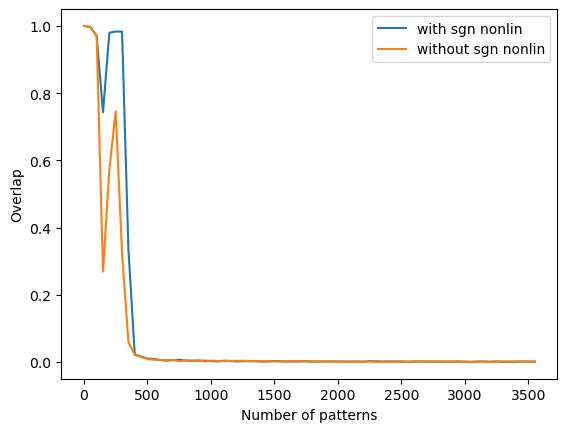

In [19]:
plt.plot(Npatts_list,np.average(final_noisy_overlap_list,axis=1), label='with sgn nonlin')
plt.plot(Npatts_list,np.average(final_clean_overlap_list,axis=1), label='without sgn nonlin')
# plt.errorbar(Npatts_list,np.average(final_noisy_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy, final')
# plt.errorbar(Npatts_list,np.average(final_clean_overlap_list,axis=1),yerr=np.std(final_clean_overlap_list,axis=1), label='clean, final')
plt.xlabel('Number of patterns')
plt.ylabel('Overlap')
plt.legend()

### 4.2 Performance Curve Analysis

Generate capacity curves showing the effect of sequence length on learning performance:

**Plot elements**:
- **X-axis**: Number of patterns in sequence (1 to 3600)
- **Y-axis**: Average overlap score across 3 runs (performance measure)
- **Blue line**: Performance with sign nonlinearity applied at each timestep
- **Orange line**: Performance without sign nonlinearity (continuous outputs)

**Expected patterns**:
- **Capacity limit**: Performance should degrade as sequence length approaches network bottleneck
- **Nonlinearity effect**: Sign function may improve robustness but reduce gradual learning
- **Critical transition**: Sharp drop in performance when capacity is exceeded

**Interpretation**:
- High overlap (near 1.0) indicates successful sequence learning
- Low overlap indicates network cannot maintain sequential coherence
- Comparison reveals whether discrete or continuous representations work better

In [ ]:
np.save("seq_wo_sgn_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+".npy", final_clean_overlap_list)
np.save("seq_w_sgn_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+".npy", final_noisy_overlap_list)
np.save("Npatts_list_seq.npy", Npatts_list)



### 4.3 Experimental Data Preservation

Save experimental results for later analysis and comparison:

**Saved files**:
- **`seq_wo_sgn_overlap_list_*.npy`**: Performance data without sign nonlinearity
- **`seq_w_sgn_overlap_list_*.npy`**: Performance data with sign nonlinearity  
- **`Npatts_list_seq.npy`**: Sequence length values used in experiment

**Filename encoding**: Includes network architecture parameters (Np, Ns, Ng) and number of runs for full reproducibility

**Purpose**: 
- **Reproducibility**: Results can be reloaded and replotted without re-running experiments
- **Comparison**: Different network architectures can be compared systematically
- **Statistical analysis**: Raw data available for error bars, significance testing, etc.